<a href="https://colab.research.google.com/github/kamilpopowski/Owned_Outcomes/blob/master/OwnedOutcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential #pozwala na budowanie modelu warstwa po warstwie
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D #Dense - przypisujemy mu finkcje aktywacyjną; Flatten - 'wypłaszcza' dane z obrazków; Conv2D - odpowiedzialna za konwolucje;


import numpy as np
import matplotlib.pyplot as plt #zastosowano do wyświetlenia obrazków oraz zobrazowania na późniejszym wykresie dokładności oraz straty trenowania i walidacji  
import seaborn as sb #seaborn zapewnia lepszy wygląd wykresów
sb.set() #włączenie seaborn

print(tf.__version__)

1.15.0


In [0]:
fashion_mnist = keras.datasets.fashion_mnist #pobranie obrazków treningowych oraz testowych   

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() #utworzenie tuplu treningowych oraz testowych


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] #tablica zawierająca nazwy przedmiotów znajdujących się w zbiorze danych 

In [62]:
print(train_images.shape) #wyświetlenie liczby próbek przeznaczonych do trenowania oraz rozmiaru obrazków
print('liczba próbek: ', train_images.shape[0])
print('rozmiar obrazka: ', train_images[0].shape)

(60000, 28, 28)
liczba próbek:  60000
rozmiar obrazka:  (28, 28)


(-0.5, 27.5, 27.5, -0.5)

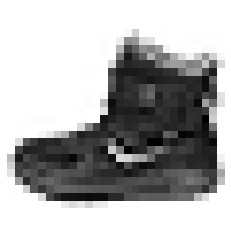

In [63]:
plt.figure() #wyświetlenie przykładowego obrazu ze zbioru danych treningowych
plt.imshow(train_images[0], cmap='Greys')
plt.axis('off')

In [64]:
print(keras.backend.image_data_format()) #wyświetlenie rodzaju zapisu danych

channels_last


In [65]:
#Dane przyjmują dwa rodzaje zapisu (channelr last lub channel first), do sieci należy podać liczbę kanałów, w tworzonej sieci mamy 1 kanał ponieważ obrazki są czarno - białe
#w przypadku channels last kanał podajemy na końcu tj. 28, 28, 1, w przypadku channel first kanał podajemy na początku - 1, 28, 28

img_rows, img_cols = 28, 28
if keras.backend.image_data_format() == 'channel_first':  #jeżeli nasza opcja to przekształcamy dane tak aby na początku była liczba próbek, następnie kanał i rozmiar obrazka
  train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
  test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
  input_shape = (1, img_rows, img_cols)
else: #w przeciwnym wypadku kanał ustawiamy na ostatnim miejscu
  train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1) 
  test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)

print(input_shape)

(28, 28, 1)


In [66]:
len(train_labels)

60000

In [67]:
train_labels[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [68]:
train_images = train_images.astype('float32') #przekonwertowanie dancyh na typ float
test_images = test_images.astype('float32') 

train_images /= 255 #wystandaryzowanie danych do przedziału od 0 do 1 (pozwala to na lepszą nauke sieci)
test_images /= 255

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [69]:
#metoda jako argumenty przyjmuje odpowiednio dla obu zmiennych train_labels, test_labels oraz liczbe klas następnie konwertuje klasy na binarną macierz
#dalsze omówienie poniżej
train_labels = keras.utils.to_categorical(train_labels, num_classes=10) 
test_labels = keras.utils.to_categorical(test_labels, num_classes=10)

print(train_labels.shape)
print(test_labels.shape)

(60000, 10)
(10000, 10)


In [70]:
train_labels[0:10]  
#w wektorze każda wartość liczbowa w indeksie odpowiada wartości w tablicy class_names, miejsce 0 - 'T-shirt/top', 1 - 'Trouser', 2 - 'Pullover' itd.
#w chwili gdy na obrazku rozpoznana zostanie np. 'Dress' wartość 1 w wektorze ustawi się na 4 miejscu
#poniżej wyświetlono wektory dla 10 obrazków, wynika z nich, że 'Dress' znajduje się na 4 obrazku

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [71]:
model = Sequential() #utworzenie obiektu klasy Sequential, dzięki temu zabiegowi model można tworzyć warstwa po warstwie
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))#filters - liczba filtrów za pomocą których sieć tworzy mapę cech, kerner_size - rozmiar zastosowanego filtru
#activation - funkcja aktywacji, zastosowano funkcję relu (dla wartości ujemnych funkcja przyjmuje wartość 0, aktywowana jest dla wartości dodatnich)
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))#warstwa MaxPooling zmniejsza złożoność problemu. pool_size jest rozmiarem okna ekstrakcji, które 'chodzi' po pikselach
model.add(Flatten())
model.add(Dense(units=128, activation='relu')) # units=128 - liczba neuronów
model.add(Dense(units=10, activation='softmax')) #units=10 - liczba klas, które chcemy przewidzieć, funkcja softmax zwróci nam prawdopodobieństwo poszczególnych klas

model.summary() #podsumowanie modelu

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
____________________________________________

In [0]:
model.compile(optimizer='adadelta', 
              loss='categorical_crossentropy',
              metrics=['accuracy']) #skompilowanie modelu, jako argumenty podany został optymalozator, funkcja straty oraz metryka 

In [73]:
his = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_data=(test_images, test_labels)) #metoda fit trenuje model dla określonej liczby epok
#jako argumenty podane są dane treningowe, batch_size - liczba pobieranych próbek, epochs - liczba epok, validation_data - dane testowe, na ich podstawie można oszacować stratę

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 64us/step - loss: 0.4968 - acc: 0.8220 - val_loss: 0.4205 - val_acc: 0.8449
Epoch 2/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.2983 - acc: 0.8909 - val_loss: 0.3085 - val_acc: 0.8892
Epoch 3/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.2473 - acc: 0.9098 - val_loss: 0.3141 - val_acc: 0.8845
Epoch 4/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.2115 - acc: 0.9222 - val_loss: 0.2596 - val_acc: 0.9048
Epoch 5/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.1828 - acc: 0.9322 - val_loss: 0.2385 - val_acc: 0.9169
Epoch 6/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.1590 - acc: 0.9414 - val_loss: 0.2486 - val_acc: 0.9128
Epoch 7/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1354 - acc: 0.9497 - val_loss: 0.2646 - val_acc

In [0]:
def make_accuracy_plot(his): #dwie funkcje, które utworzą wykres przedstawiający historie nauki 

  acc, val_acc = his.history['acc'], his.history['val_acc']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(10, 8))
  plt.plot(epochs, acc, label='dokladnosc trenowania', marker='o')
  plt.plot(epochs, val_acc, label='dokladnosc walidacji', marker='o')
  plt.legend()
  plt.title('dokladnosc trenowania i walidacji')
  plt.xlabel('epoki')
  plt.ylabel('dokladnosc')
  plt.show()

def make_loss_plot(his):
  loss, val_loss = his.history['loss'], his.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10, 8))
  plt.plot(epochs, loss, label='strata trenowania', marker='o')
  plt.plot(epochs, val_loss, label='strata walidacji', marker='o')
  plt.legend()
  plt.title('strata trenowania i walidacji')
  plt.xlabel('epoki')
  plt.ylabel('strata')
  plt.show()

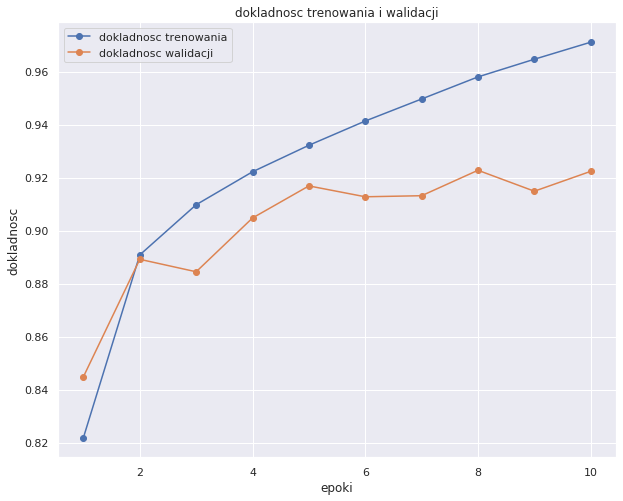

In [75]:
make_accuracy_plot(his) #wykres przedstawia odpowiednio dokładność trenowania orazdokładnośc walidacji

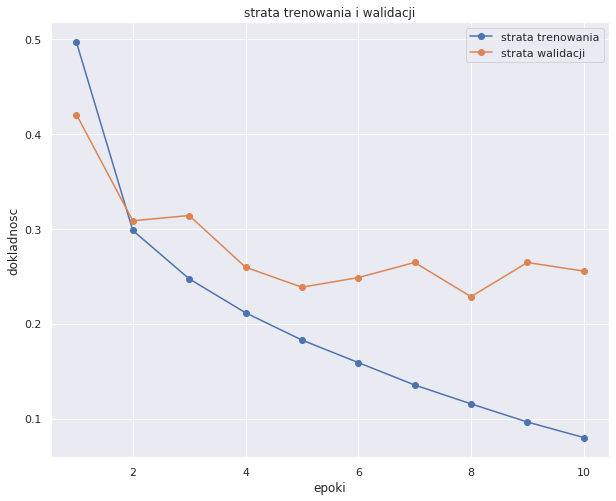

In [76]:
make_loss_plot(his) #na wykresie zaobserwowano, że model uległ przeuczeniu po 3 epoce na co wskazuje pomarańczowa linia

In [97]:
test_labels[0:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)